In [1]:
# Setup logging
from timeseria import logger
logger.setup(level='INFO')

# Set default plot type as image
import os
os.environ["DEFAULT_PLOT_TYPE"] = "image"

⚠️ In this notebook, plots are configured to be rendered as images because otherwise they won't display correctly on GitHub or when the notebook is loaded (usually because not [trusted](https://stackoverflow.com/questions/44943646/jupyter-notebook-not-trusted)). To get interactive plots, remove the line above (or change it to "interactive") and re-run the notebook.

# Anomaly detection on temperature and humidity with LSTM


This notebook showcases the LSTM anomaly detector of [Timeseria](https://github.com/sarusso/Timeseria).

Anomlay detection is achieved in a model-based dashion, meaning that a forecaster is trained to make predictions which are than compared to the actual data: the more they differ, the grater the anomaly index will be.

The first step is to get a demo temperature and humidity time series, slice it to make it shorter, and resample it to one hour:

In [2]:
from timeseria import TEST_DATASETS_PATH
from timeseria.datastructures import TimeSeries
timeseries = TimeSeries.from_csv(TEST_DATASETS_PATH + 'humitemp_long.csv')[1500:5000].resample('1h')

[INFO] timeseria.transformations: Using auto-detected sampling interval: 615.0s
[INFO] timeseria.transformations: Resampled 3500 DataTimePoints in 598 DataTimePoints


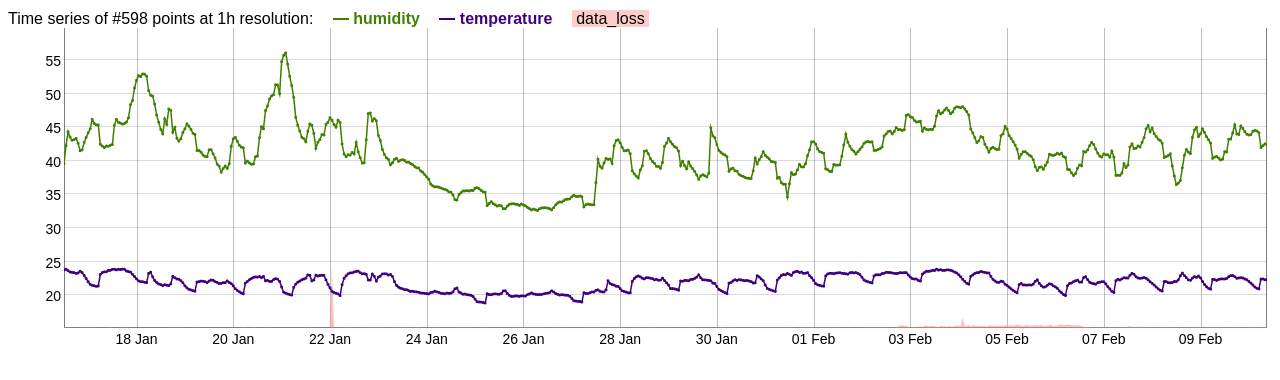

In [3]:
timeseries.plot()

### LSTM anomaly detection without context
Let's fit, inspect and apply the LSTM anomaly detector wihtout context, which is the default behaviour. This means that only past data will be used to make the predictions, not current step, contextual one.

In [4]:
from timeseria.models import LSTMAnomalyDetector
anomaly_detector = LSTMAnomalyDetector()
anomaly_detector.fit(timeseries, epochs=5, verbose=False, with_context=False, error_distribution='norm', reproducible=True)

[INFO] timeseria.models.forecasters: Using default window size of 3
[INFO] timeseria.models.forecasters: Using default features: values
[INFO] timeseria.models.anomaly_detectors: Predictive model(s) fitted, now evaluating...
[INFO] timeseria.models.anomaly_detectors: Computing actual vs predicted for "humidity"...
[INFO] timeseria.models.anomaly_detectors: Computing actual vs predicted for "temperature"...
[INFO] timeseria.models.anomaly_detectors: Model(s) evaluated, now computing the error distribution(s)...
[WARNING] timeseria.models.anomaly_detectors: The error distribution for "humidity" (norm) ks p-value is low (0.01128862678914733). Expect issues. In case of math domain errors, try using lower index boundaries.
[WARNING] timeseria.models.anomaly_detectors: The error distribution for "humidity" is not centered in (almost) zero, but in -0.21248164432553296. Expect issues.
[INFO] timeseria.models.anomaly_detectors: Anomaly detector fitted



Details for: "humidity"
Predictive model avg error (abs): 1.4342217646395232
Predictive model min error (abs): 0.00021774974436539196
Predictive model max error (abs): 8.065870218589566
Error distribution: norm
Error distribution params: {'loc': -0.21248164432553296, 'scale': 1.8287463062432296}
Error distribution stats: {'sumsquare_error': 0.1427120418980971, 'aic': 823.589887288205, 'bic': 832.3636459269303, 'kl_div': inf, 'ks_statistic': 0.06571438022187559, 'ks_pvalue': 0.01128862678914733}


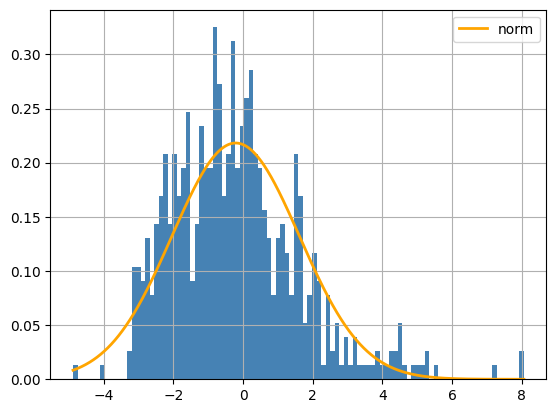


Details for: "temperature"
Predictive model avg error (abs): 0.48985649516319485
Predictive model min error (abs): 0.0017212691291454973
Predictive model max error (abs): 1.8005891712391744
Error distribution: norm
Error distribution params: {'loc': -0.0024779073024786655, 'scale': 0.5898635664894825}
Error distribution stats: {'sumsquare_error': 1.9201691064536741, 'aic': 369.12844899208795, 'bic': 377.9022076308132, 'kl_div': inf, 'ks_statistic': 0.054965757444441155, 'ks_pvalue': 0.05319252675818775}


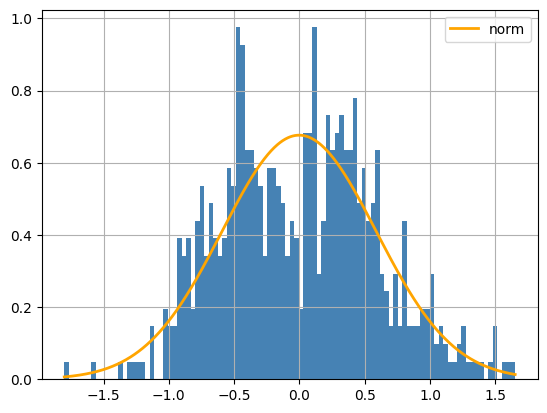

In [5]:
anomaly_detector.inspect()

In [6]:
result_timeseries = anomaly_detector.apply(timeseries)

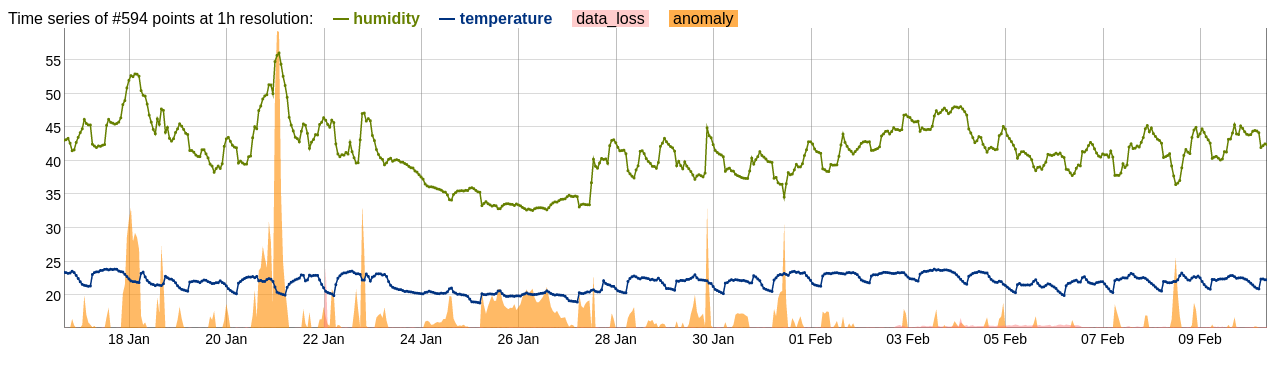

In [7]:
result_timeseries.plot()

### LSTM anomaly detection with context
Let's now fit, inspect and apply the LSTM anomaly detector which will instead make use of context. It will be slower, but much more powerful since when evaluating the anomaly index for a given data label at a given step, also the behavipur of all the others will be taken into account.

In [8]:
anomaly_detector = LSTMAnomalyDetector()
anomaly_detector.fit(timeseries, epochs=5, verbose=False, with_context=True, error_distribution='norm', reproducible=True)

[INFO] timeseria.models.forecasters: Using default window size of 3
[INFO] timeseria.models.forecasters: Using default features: values
[INFO] timeseria.models.forecasters: Using default window size of 3
[INFO] timeseria.models.forecasters: Using default features: values
[INFO] timeseria.models.anomaly_detectors: Predictive model(s) fitted, now evaluating...
[INFO] timeseria.models.anomaly_detectors: Computing actual vs predicted for "humidity"...
[INFO] timeseria.models.anomaly_detectors: Computing actual vs predicted for "temperature"...
[INFO] timeseria.models.anomaly_detectors: Model(s) evaluated, now computing the error distribution(s)...
[WARNING] timeseria.models.anomaly_detectors: The error distribution for "humidity" is not centered in (almost) zero, but in -0.9084797073513535. Expect issues.
[WARNING] timeseria.models.anomaly_detectors: The error distribution for "temperature" is not centered in (almost) zero, but in -0.32955779978558053. Expect issues.
[INFO] timeseria.model


Details for: "humidity"
Predictive model avg error (abs): 1.24862723400959
Predictive model min error (abs): 0.0016471374896696034
Predictive model max error (abs): 5.366560356721692
Error distribution: norm
Error distribution params: {'loc': -0.9084797073513535, 'scale': 1.2924104290423724}
Error distribution stats: {'sumsquare_error': 0.18094972872892554, 'aic': 856.478540079549, 'bic': 865.2522987182743, 'kl_div': inf, 'ks_statistic': 0.05470185979246189, 'ks_pvalue': 0.05506461766444459}


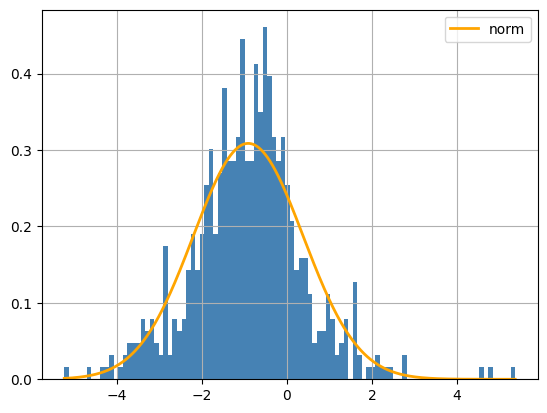


Details for: "temperature"
Predictive model avg error (abs): 0.48322686990777186
Predictive model min error (abs): 0.0009115528157650488
Predictive model max error (abs): 1.855193148666146
Error distribution: norm
Error distribution params: {'loc': -0.32955779978558053, 'scale': 0.47927934645032355}
Error distribution stats: {'sumsquare_error': 2.3792838808746857, 'aic': 394.4485804199162, 'bic': 403.22233905864147, 'kl_div': inf, 'ks_statistic': 0.05488155216256663, 'ks_pvalue': 0.053783831083598965}


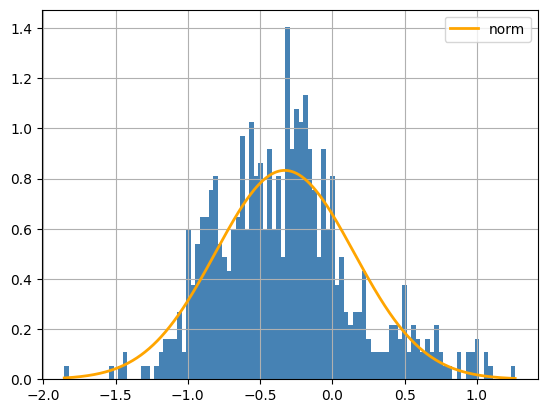

In [9]:
anomaly_detector.inspect()

In [10]:
result_timeseries = anomaly_detector.apply(timeseries)

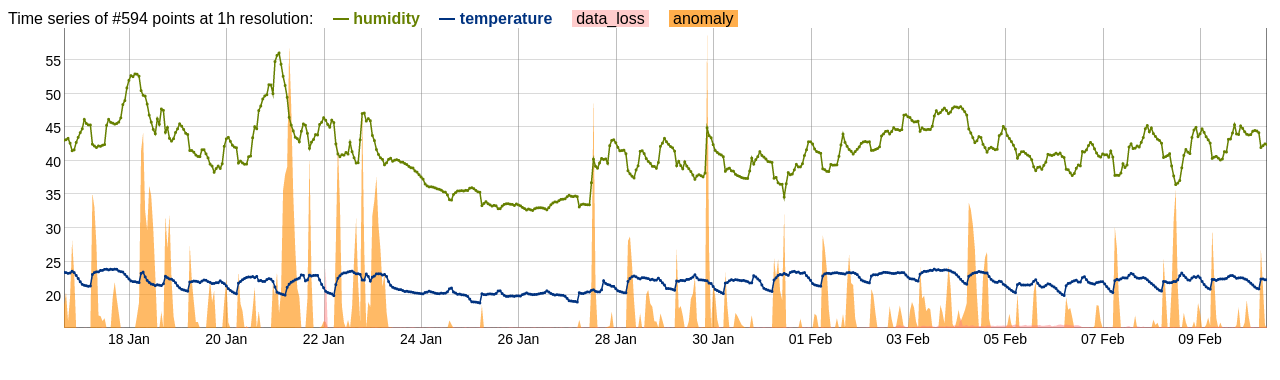

In [11]:
result_timeseries.plot()